
... ***CURRENTLY UNDER DEVELOPMENT*** ...


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, Aggregate_WavesFamilies, Intradaily_Hydrograph
from teslakit.util.time_operations import xds_limit_dates, xds_reindex_daily, xds_common_dates_daily

from teslakit.plotting.climate_emulator import Plot_Complete



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'

# offshore
db = Database(p_data)
db.SetSite('ROI')

# climate change - S4
db_S4 = Database(p_data)
db_S4.SetSite('ROI_CC_S4')


# climate emulator simulation modified path
p_S4_CE_sims = op.join(db_S4.paths.site.EXTREMES.climate_emulator, 'Simulations')

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
CE.Load()
CE.Set_Simulation_Folder(p_S4_CE_sims)

n_sims_DWTs = 10



## Simulated Waves and Climate Data

In [3]:
# --------------------------------------
# aux. functions

def waves_hourly(CE, n_sims_DWTs, n_sim_ce=0):
    '''
    Generate hourly simulation output. 
    
    - join DWTs-WVs Climate emulator simulations for all n_sims_DWTs
    - aggregate simulated waves storms
    - generate hourly hydrographs
    - calculates AWL
    
    return xarray.Dataset with dims: n_sim (DWTs-WVs), time (hourly)
    '''

    # iterate simulations
    ls_hy = []
    for n in range(n_sims_DWTs):
        _, TCS_sim, WVS_upd = CE.LoadSim(n_sim = n)    
        WVS_upd = WVS_upd.isel(n_sim = n_sim_ce)  # (one CE sim. for each DWT sim.)
        TCS_sim = TCS_sim.isel(n_sim = n_sim_ce)

        # Aggregate waves families
        wvs_agr = Aggregate_WavesFamilies(WVS_upd)

        # Calculate Intradaily hourly hydrographs for simulated storms
        hy = Intradaily_Hydrograph(wvs_agr, TCS_sim)
        ls_hy.append(hy)
        
    # combine hourly simulations
    hy = xr.concat(ls_hy, 'n_sim')

    # Calculate hourly Atmospheric Water Level and Total Water Level
    hy['AWL'] = AWL(hy.Hs, hy.Tp)

    return hy


In [4]:
# --------------------------------------
# Climate Emulator extremes model output

# Generate hourly waves xarray.Dataset using intradaily hydrographs
WVS_sim_h = waves_hourly(CE, n_sims_DWTs)  
db_S4.Save_SIM_Waves_hourly(WVS_sim_h)

print(WVS_sim_h)


<xarray.Dataset>
Dimensions:  (n_sim: 10, time: 8765833)
Coordinates:
  * time     (time) object 2000-01-01 2000-01-01T01:00:00 ... 3000-01-01
Dimensions without coordinates: n_sim
Data variables:
    Hs       (n_sim, time) float64 2.063 2.057 2.05 ... 0.5012 0.4712 0.4412
    Tp       (n_sim, time) float32 9.734059 9.734059 ... 6.9411745 13.976438
    Dir      (n_sim, time) float32 38.314224 38.314224 ... 45.322403 349.13596
    SS       (n_sim, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AWL      (n_sim, time) float64 0.6007 0.5998 0.5989 ... 0.2111 0.2047 0.3989
Attributes:
    source:   teslakit_v0.9.1



## Complete Simulation: load covariates and merge with hourly waves

In [5]:
# --------------------------------------
# Covariates: AWTs, DWTs, MJO, MMSL, AT

# Generate hourly covariates data
CVS_sim_h = db.Generate_SIM_Covariates(total_sims=n_sims_DWTs)
db_S4.Save_SIM_Covariates_hourly(CVS_sim_h)


# --------------------------------------
# Complete simulation output 
d1, d2 = xds_limit_dates([WVS_sim_h, CVS_sim_h])
WVS_sim_h = WVS_sim_h.sel(time = slice(d1, d2))
CVS_sim_h = CVS_sim_h.sel(time = slice(d1, d2))

# merge all data
SIM_COMPLETE_h = xr.merge([WVS_sim_h, CVS_sim_h])

# calculate TWL and level
SIM_COMPLETE_h['TWL'] = SIM_COMPLETE_h['AWL'] + SIM_COMPLETE_h['SS'] + SIM_COMPLETE_h['AT'] + SIM_COMPLETE_h['MMSL']
SIM_COMPLETE_h['level'] = SIM_COMPLETE_h['SS'] + SIM_COMPLETE_h['AT'] + SIM_COMPLETE_h['MMSL']

# make a daily freq. file
SIM_COMPLETE_d = xds_reindex_daily(SIM_COMPLETE_h)

# store all data
db_S4.Save_SIM_Complete_hourly(SIM_COMPLETE_h)
db_S4.Save_SIM_Complete_daily(SIM_COMPLETE_d)


print(SIM_COMPLETE_h)


<xarray.Dataset>
Dimensions:  (n_sim: 10, time: 8765832)
Coordinates:
  * time     (time) object 2000-01-01 ... 2999-12-31T23:00:00
Dimensions without coordinates: n_sim
Data variables:
    Hs       (n_sim, time) float64 2.063 2.057 2.05 ... 0.5312 0.5012 0.4712
    Tp       (n_sim, time) float32 9.734059 9.734059 ... 6.9411745 6.9411745
    Dir      (n_sim, time) float32 38.314224 38.314224 ... 45.322403 45.322403
    SS       (n_sim, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AWL      (n_sim, time) float64 0.6007 0.5998 0.5989 ... 0.2174 0.2111 0.2047
    AWT      (n_sim, time) int64 5 5 5 5 5 5 5 5 5 5 5 ... 3 3 3 3 3 3 3 3 3 3 3
    MJO      (n_sim, time) int64 23 23 23 23 23 23 23 ... 25 25 25 25 25 25 25
    DWT      (n_sim, time) int64 27 27 27 27 27 27 27 ... 16 16 16 16 16 16 16
    MMSL     (n_sim, time) float32 -0.022942495 -0.022942495 ... -0.101341076
    AT       (time) float32 1.2538135 1.307724 ... 0.57611704 0.38318345
    TWL      (n_sim, time) floa

In [6]:
# Prepare storms version (waves by families, used at nearshore RBF reconstruction)

n_sim_ce = 0  # (one CE sim. for each DWT sim.)

# iterate each DWT-WVS simulation
l_sims = []
for n in range(n_sims_DWTs):
    _, _, WVS_upd = CE.LoadSim(n_sim = n)    
    WVS_upd = WVS_upd.isel(n_sim = n_sim_ce) 

    # aggregated Hs, Tp, Dir
    WVS_a = Aggregate_WavesFamilies(WVS_upd)
    for vn in ['Hs', 'Tp', 'Dir']:
        WVS_upd[vn] = WVS_a[vn]
    
    # fix min and max times
    SIM_d = SIM_COMPLETE_d.isel(n_sim=n)
    
    dcs = xds_common_dates_daily([WVS_upd, SIM_d])
    WVS_upd = WVS_upd.sel(time=slice(dcs[0], dcs[-1]))
    SIM_d = SIM_d.sel(time=slice(dcs[0], dcs[-1]))
    
    # add all variables to storms version file
    SIM_COMPLETE_ms = WVS_upd.copy()
    for vn in SIM_d.variables:
        if vn not in SIM_COMPLETE_ms:
            SIM_COMPLETE_ms[vn] = SIM_d[vn].sel(time=SIM_COMPLETE_ms.time)   
    l_sims.append(SIM_COMPLETE_ms)
    

# store complete data for each simulation
db_S4.Save_SIM_Complete_storms(l_sims)


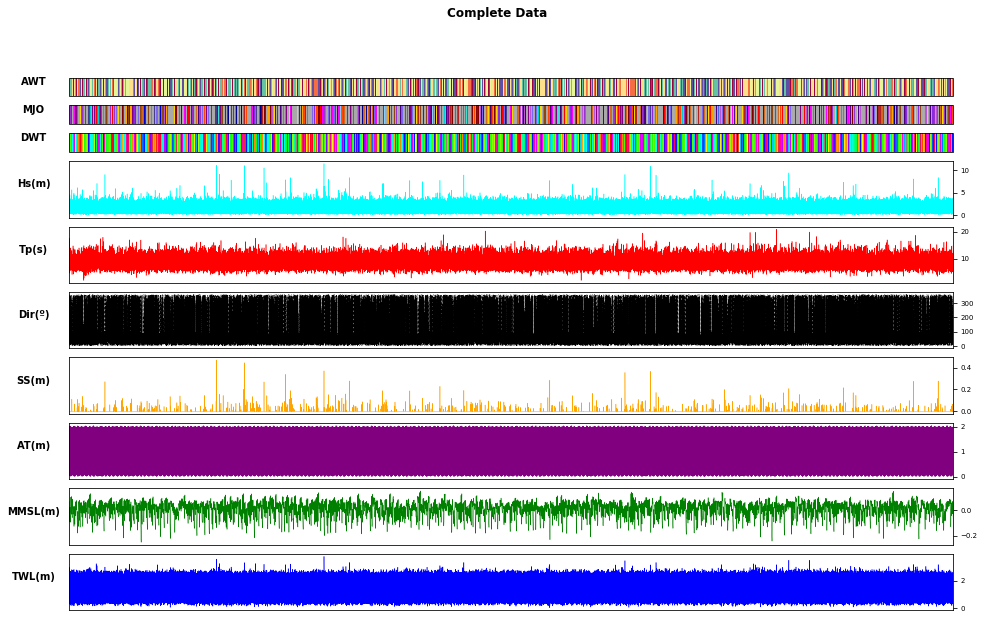

In [7]:
# Plot Simulation 

Plot_Complete(SIM_COMPLETE_h.sel(n_sim=0));
